# LSTM with HMM Classification Filter

This notebook evaluates the effect of applying an HMM classification filter to LSTM predictions.

**Method**: The HMM filter exploits temporal consistency using a sticky transition model.

**Stickiness values tested**: 0.7, 0.85, 0.95

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

STICKINESS_VALUES = [0.7, 0.85, 0.95]

print('='*60)
print('LSTM with HMM Classification Filter')
print(f'Device: {device}')
print('='*60)

LSTM with HMM Classification Filter
Device: cuda


## HMM Classification Filter

In [2]:
class ClassificationFilter:
    def __init__(self, n_classes, confusion_matrix=None, stickiness=0.9):
        self.n_classes = n_classes
        self.stickiness = stickiness
        
        if confusion_matrix is not None:
            self.emission = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
        else:
            accuracy = 0.8
            self.emission = np.full((n_classes, n_classes), (1 - accuracy) / (n_classes - 1))
            np.fill_diagonal(self.emission, accuracy)
        
        self.transition = np.full((n_classes, n_classes), (1 - stickiness) / (n_classes - 1))
        np.fill_diagonal(self.transition, stickiness)
        
        self.belief = np.ones(n_classes) / n_classes
    
    def reset(self):
        self.belief = np.ones(self.n_classes) / self.n_classes
    
    def update(self, observation):
        predicted_belief = self.transition.T @ self.belief
        likelihood = self.emission[:, observation]
        posterior = predicted_belief * likelihood
        posterior_sum = posterior.sum()
        if posterior_sum > 0:
            posterior /= posterior_sum
        else:
            posterior = np.ones(self.n_classes) / self.n_classes
        self.belief = posterior
        return np.argmax(posterior), posterior
    
    def filter_sequence(self, observations, reset_on_run=None):
        self.reset()
        estimates = []
        prev_run = None
        
        for i, obs in enumerate(observations):
            if reset_on_run is not None:
                current_run = reset_on_run[i]
                if prev_run is not None and current_run != prev_run:
                    self.reset()
                prev_run = current_run
            
            est, _ = self.update(obs)
            estimates.append(est)
        
        return np.array(estimates)

print('ClassificationFilter defined')

ClassificationFilter defined


## Define Model Architecture

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

print('Model class defined')

Model class defined


## Load Model and Data

In [4]:
print('\n[Step 1/5] Loading trained LSTM model...')

model_path = MODEL_DIR / 'lstm_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']

num_classes = len(label_classes)
class_names = [str(int(c)) for c in label_classes]

model = LSTMClassifier(
    input_size=len(features),
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    num_classes=num_classes,
    dropout=config['dropout']
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded: {len(features)} features, {num_classes} classes')


[Step 1/5] Loading trained LSTM model...


Model loaded: 52 features, 18 classes


In [5]:
print('\n[Step 2/5] Loading test dataset...')
start_time = time.time()

test_data = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

print(f'Test data loaded in {time.time() - start_time:.2f}s')
print(f'  Shape: {test_data.shape}')


[Step 2/5] Loading test dataset...


Test data loaded in 9.94s
  Shape: (2880000, 57)


## Create Dataset and Generate Predictions

In [6]:
class SimulationRunDataset(Dataset):
    def __init__(self, df, features, scaler_mean, scaler_scale, label_classes, sequence_length=10):
        self.sequence_length = sequence_length
        self.class_to_idx = {c: i for i, c in enumerate(label_classes)}
        
        self.sequences = []
        self.labels = []
        self.run_ids = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = group[features].values
            X = (X - scaler_mean) / scaler_scale
            
            run_id = f'{fault}_{run}'
            for i in range(len(X) - sequence_length + 1):
                self.sequences.append(X[i:i+sequence_length])
                self.labels.append(self.class_to_idx[fault])
                self.run_ids.append(run_id)
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

print('Dataset class defined')

Dataset class defined


In [7]:
print('\n[Step 3/5] Generating raw predictions...')
pred_start = time.time()

seq_len = config['sequence_length']
test_dataset = SimulationRunDataset(test_data, features, scaler_mean, scaler_scale, label_classes, seq_len)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0)

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

y_pred_raw = np.array(all_preds)
y_test = np.array(all_labels)
run_ids = np.array(test_dataset.run_ids)

print(f'Predictions generated in {time.time() - pred_start:.2f}s')
print(f'  Raw accuracy: {accuracy_score(y_test, y_pred_raw):.4f}')


[Step 3/5] Generating raw predictions...


Predictions generated in 56.68s
  Raw accuracy: 0.9914


## Apply HMM Filter

In [8]:
print('\n[Step 4/5] Applying HMM filter...')

cm_raw = confusion_matrix(y_test, y_pred_raw)

filtered_predictions = {}

for stickiness in STICKINESS_VALUES:
    filter_start = time.time()
    
    hmm_filter = ClassificationFilter(
        n_classes=num_classes,
        confusion_matrix=cm_raw.astype(float),
        stickiness=stickiness
    )
    
    y_pred_filtered = hmm_filter.filter_sequence(y_pred_raw, reset_on_run=run_ids)
    filtered_predictions[stickiness] = y_pred_filtered
    
    acc = accuracy_score(y_test, y_pred_filtered)
    print(f'  Stickiness {stickiness}: Accuracy = {acc:.4f} (time: {time.time() - filter_start:.2f}s)')

print('\nHMM filtering complete')


[Step 4/5] Applying HMM filter...


  Stickiness 0.7: Accuracy = 0.9914 (time: 21.64s)


  Stickiness 0.85: Accuracy = 0.9914 (time: 21.84s)


  Stickiness 0.95: Accuracy = 0.9914 (time: 22.00s)

HMM filtering complete


## Compute Metrics

In [9]:
print('\n[Step 5/5] Computing metrics...')

def compute_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'per_class_f1': dict(zip(class_names, f1_score(y_true, y_pred, average=None)))
    }

raw_metrics = compute_metrics(y_test, y_pred_raw)
filtered_metrics = {s: compute_metrics(y_test, filtered_predictions[s]) for s in STICKINESS_VALUES}

print('\n' + '='*80)
print('METRICS COMPARISON: RAW vs HMM-FILTERED')
print('='*80)
print(f"\n{'Method':<25} {'Accuracy':>10} {'Bal.Acc':>10} {'F1(W)':>10}")
print('-'*55)
print(f"{'Raw'::<25} {raw_metrics['accuracy']:>10.4f} {raw_metrics['balanced_accuracy']:>10.4f} {raw_metrics['f1_weighted']:>10.4f}")

for stickiness in STICKINESS_VALUES:
    m = filtered_metrics[stickiness]
    print(f"{'HMM (y=' + str(stickiness) + ')':<25} {m['accuracy']:>10.4f} {m['balanced_accuracy']:>10.4f} {m['f1_weighted']:>10.4f}")

print('='*80)


[Step 5/5] Computing metrics...



METRICS COMPARISON: RAW vs HMM-FILTERED

Method                      Accuracy    Bal.Acc      F1(W)
-------------------------------------------------------
Raw::::::::::::::::::::::     0.9914     0.9914     0.9914
HMM (y=0.7)                   0.9914     0.9914     0.9914
HMM (y=0.85)                  0.9914     0.9914     0.9915
HMM (y=0.95)                  0.9914     0.9914     0.9915


## Visualizations

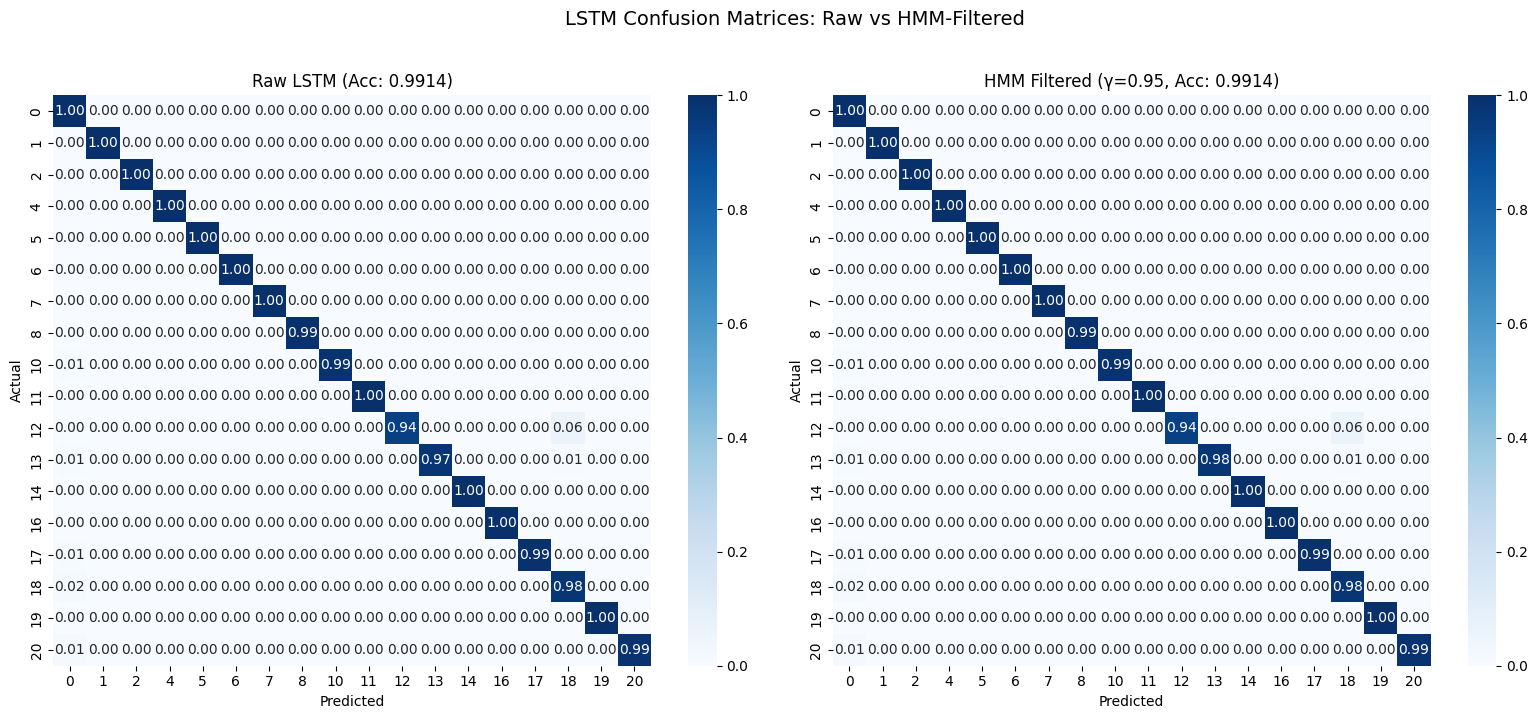

Saved to ../outputs/figures/lstm_hmm_confusion_matrices.png


In [10]:
best_stickiness = max(STICKINESS_VALUES, key=lambda s: filtered_metrics[s]['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

cm_raw_norm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_raw_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0], vmin=0, vmax=1)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Raw LSTM (Acc: {raw_metrics["accuracy"]:.4f})')

cm_hmm = confusion_matrix(y_test, filtered_predictions[best_stickiness])
cm_hmm_norm = cm_hmm.astype('float') / cm_hmm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_hmm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1], vmin=0, vmax=1)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'HMM Filtered (γ={best_stickiness}, Acc: {filtered_metrics[best_stickiness]["accuracy"]:.4f})')

plt.suptitle('LSTM Confusion Matrices: Raw vs HMM-Filtered', fontsize=14, y=1.02)
plt.tight_layout()
output_file = FIGURES_DIR / 'lstm_hmm_confusion_matrices.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [11]:
best_metrics = filtered_metrics[best_stickiness]

results = {
    'model': 'LSTM',
    'method': 'HMM Classification Filter',
    'test_samples': len(y_test),
    'n_classes': num_classes,
    'raw_metrics': raw_metrics,
    'filtered_metrics': {str(k): v for k, v in filtered_metrics.items()},
    'best_stickiness': best_stickiness,
    'best_improvement': {
        'accuracy_delta': best_metrics['accuracy'] - raw_metrics['accuracy'],
        'f1_weighted_delta': best_metrics['f1_weighted'] - raw_metrics['f1_weighted'],
        'error_reduction_pct': ((1 - raw_metrics['accuracy']) - (1 - best_metrics['accuracy'])) / (1 - raw_metrics['accuracy']) * 100 if raw_metrics['accuracy'] < 1 else 0
    },
    'stickiness_values_tested': STICKINESS_VALUES
}

output_file = METRICS_DIR / 'lstm_hmm_filter_results.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f'Saved to {output_file}')

Saved to ../outputs/metrics/lstm_hmm_filter_results.json


In [12]:
print('\n' + '='*60)
print('LSTM HMM Classification Filter Complete!')
print('='*60)
print(f'\nRaw Accuracy: {raw_metrics["accuracy"]:.4f}')
print(f'Best HMM (y={best_stickiness}): {best_metrics["accuracy"]:.4f}')
print(f'Improvement: {results["best_improvement"]["accuracy_delta"]:+.4f}')
print(f'Error Reduction: {results["best_improvement"]["error_reduction_pct"]:.1f}%')
print('='*60)


LSTM HMM Classification Filter Complete!

Raw Accuracy: 0.9914
Best HMM (y=0.95): 0.9914
Improvement: +0.0001
Error Reduction: 0.7%
